In [1]:
using ITensors
using Plots
using KrylovKit
using LinearAlgebra
using MKL

ITensors.op(::OpName"z", ::SiteType"S=1/2") = [1, 0, 0, -1]
ITensors.op(::OpName"x", ::SiteType"S=1/2") = [0, 1, 1, 0]
ITensors.op(::OpName"n", ::SiteType"S=1/2") = [0, 0, 0, 1]

In [3]:
mutable struct RydbergObserver <: AbstractObserver
    energy_tol::Float64
    last_energy::Float64

    RydbergObserver(energy_tol=0.0) = new(energy_tol, 1000.0)
end

function ITensors.checkdone!(o::RydbergObserver; kwargs...)
    sw = kwargs[:sweep]
    energy = kwargs[:energy]
    if abs(energy - o.last_energy) / abs(energy) < o.energy_tol
        # early stopping
        return true
    end
    o.last_energy = energy
    return false
end

function ITensors.measure!(o::RydbergObserver; kwargs...)
    energy = kwargs[:energy]
    sweep = kwargs[:sweep]
    bond = kwargs[:bond]
    outputlevel = kwargs[:outputlevel]

    # if outputlevel > 0
    #     println("Sweep $sweep at bond $bond, the energy is $energy")
    # end
end

In [4]:
# assume k = 6
function blockade_radius(rabi_f)
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    return (C6 / rabi_f)^(1 / 6)
end

function interaction_strength(a, b)
    # C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    C6 = 1
    lattice_spacing = 1 # lattice constant (micrometers)

    return C6 / (abs(a - b) * lattice_spacing)^6
end

function on_site_detuning(site, N)
    det = 0
    for j = 1:N
        if j != site
            det += interaction_strength(site, j)
        end
    end
    return -0.5 * det
end

function display_mpo_elements(H)
    N = length(H)
    for n = 1:N
        println("Tensor $n of the MPO:")
        println(H[n])
        println("------")
    end
end

function interactions(site)
    os = OpSum()
    for j = 1:site-1
        os += interaction_strength(site, j), "n", site, "n", j
    end
    return os
end

function rydberg(N, rabi_f, delt)
    os = OpSum()
    for site = 1:N
        os -= 0.5 * rabi_f, "x", site
        os -= delt, "n", site
        os += interactions(site)
    end

    # println(combiner(sites)*contract(H))
    # @show H
    # display_mpo_elements(os)

    return os
end

rydberg (generic function with 1 method)

In [13]:
function bipartite_entropy(psi)
    b = Int(ceil(length(psi) / 2))
    # from ITensor docs
    ITensors.orthogonalize!(psi, b)
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
    SvN = 0.0
    for n in 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log2(p)
    end
    return SvN
end

function ground_state(N, psi0, sites, rabi_f, delt, ed_)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 15
    maxdim = [10, 10, 10, 20, 20, 40, 80, 100, 200, 200]
    cutoff = [1E-10]

    etol = 1E-10

    obs = RydbergObserver(etol)
    if ed_ == true
        energy, psi = ed(H, psi0, sites)
    end
    if ed_ == false
        energy, psi = dmrg(H, psi0; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, noise=1e-5, observer=obs, outputlevel=0, println=false)
    end
    # eigen(H, )
    # H2 = inner(H,psi,H,psi)
    # E = inner(psi',H,psi)
    # var = H2-E^2
    # println(E)
    # println(var)
    # println()

    # combin = combiner(sites)
    # println(combin * contract(psi))
    # println(energy)
    entropy = bipartite_entropy(psi)
    return entropy, energy, psi
end

function energy_gap(N, psi0, sites, rabi_f, delt)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 30
    maxdim = [10, 10, 10, 20, 20, 40, 80, 100, 200, 200]
    cutoff = [1E-12]
    weight = 1E15

    etol = 1E-12

    _, ground_energy, ground_psi = ground_state(N, psi0, sites, rabi_f, delt)

    obs = RydbergObserver(etol)
    energy, excited_psi = dmrg(H, [ground_psi], psi0; nsweeps, maxdim, cutoff, weight=weight, observer=obs)
    gap = energy - ground_energy
    # println(inner(excited_psi, ground_psi))
    return gap
end

function avg_rydberg(psi)
    avgr = 0
    for i = 1:length(psi)
        avgr += expect(psi, "n"; sites=i)
    end
    return avgr / length(psi)
end

function measure_mps(psi)
    measurement = []
    for i = 1:length(psi)
        push!(measurement, round(expect(psi, "n"; sites=i), digits=2))
    end
    return measurement
end

function ed(H, psi0, sites)
    vals, vecs, info = eigsolve(
        contract(H), contract(psi0), 1, :SR; ishermitian=true, tol=1e-20, krylovdim=30, eager=true
    )
    return vals[1], MPS(vecs[1], sites)
end

function dominant_superposition(psi)

end

dominant_superposition (generic function with 1 method)

In [7]:
function frequencies(N, resolution, separation_assumption, start, stop, stop2, psi0, sites)
    V_nn = 1
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 1

    # freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn
    freq = range(start, stop=stop, length=resolution)

    Y = freq
    X = collect(range(0.0, stop=stop2, length=resolution))

    numbers = zeros(Float64, resolution, resolution)
    # hover_text = Array{String}(undef, length(Y), length(X))
    # numbers = [[0.0 for j in 1:resolution] for i in 1:resolution]
    hover_text = [["" for i in 1:resolution] for j in 1:resolution]

    for i = 1:length(Y)
        for j = 1:length(X)
            if ((i - 1) * length(X) + j) % 200 == 0
                println((i - 1) * length(X) + j)
            end
            rabi_freq = C6/((a * Y[i])^6)
            entropy, energy, gs = ground_state(N, psi0, sites, rabi_freq, X[j] * rabi_freq)
            numbers[i, j] = avg_rydberg(gs)
            mps_state = measure_mps(gs)
            hover_text[i][j] = join(string.(mps_state), ", ")
            # hover_text[i][j] = string(numbers[i, j])
        end
    end

    # println(hover_text)
    # println(numbers)

    # Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    # numbers = reverse(numbers)
    # hover_text = reverse(hover_text)

    # Y = log2.(Y)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    # return heatmap(numbers, color=:viridis, title="Heatmap")
    return heatmap(
        X, Y, numbers,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Average Number in Rydberg"
    )
end

frequencies (generic function with 1 method)

In [24]:
function stand(N, resolution, separation_assumption, start, stop, stop2, psi0, sites, ed_=true)
    V_nn = 2 * pi * 60 * (10^6)
    V_nn = 1
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 1

    # freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn
    freq = range(start, stop=stop, length=resolution)

    Y = freq

    X = collect(range(0.0, stop=stop2, length=resolution))

    entropies = zeros(Float64, resolution, resolution)
    hover_text = [["" for i in 1:resolution] for j in 1:resolution]

    for i = 1:length(Y)
        for j = 1:length(X)
            println((i - 1) * length(X) + j)
            if ((i - 1) * length(X) + j) % 10 == 0
                println((i - 1) * length(X) + j)
            end
            # rabi_freq = (Y[i]*a / (C6^(1/6)))^(-6)
            rabi_freq = C6/((a * Y[i])^6)
            # println(Y[i])
            # rabi_freq = Y[length(Y)-i+1]
            entropy, energy, gs = ground_state(N, psi0, sites, rabi_freq, X[j] * rabi_freq, ed_)
            entropies[i, j] = entropy
            mps_state = measure_mps(gs)
            hover_text[i][j] = join(string.(mps_state), ", ")
        end
    end

    # Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    # Y = log2.(Y)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return heatmap(
        X, Y, entropies,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Bipartite Entropy"
    )
end


stand (generic function with 2 methods)

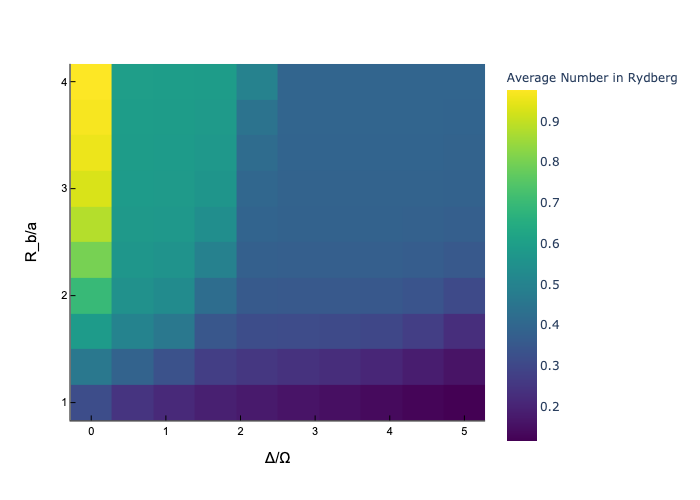

In [341]:
plotlyjs()
N=5
resolution=10
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
psi0 = randomMPS(sites; linkdims=50)
plot(frequencies(N, resolution, separation_assumption, 1, 4, 5, psi0, sites))

In [25]:
ITensors.disable_warn_order()
plotlyjs()
N=12
resolution=15
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1.25, 4, 5, psi0, sites, true))

1


2


3


4


5


6


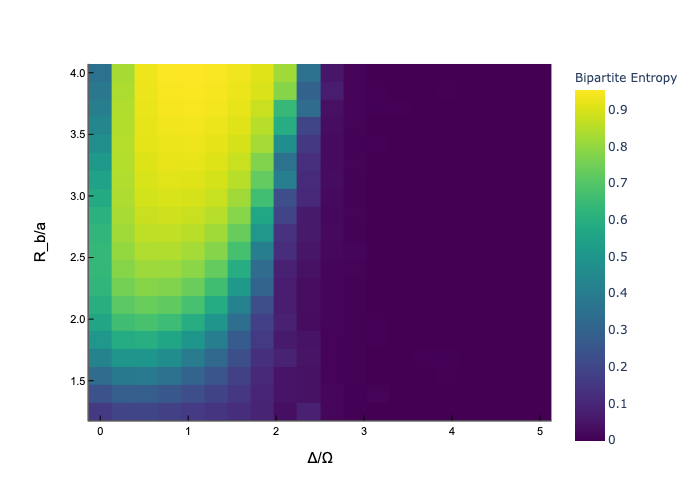

In [352]:
plotlyjs()
N=12
resolution=20
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1.25, 4, 5, psi0, sites, false))